In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [10]:
%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

In [11]:
output_dir = "../output/"

measurements = list()

for direc, sub_direc, files in os.walk(output_dir):
    if files == []:
        continue
    
    for file in files:
        if 'ndr' in file:
            t = pd.read_json(direc + '/' + files[0]).to_dict()
            
            label, flows, repeat = direc.replace(output_dir, '').split('/')

            measurements.append(
                {
                    'cpu_util': t['results']['cpu_util'],
                    'rate_tx_bps': t['results']['rate_tx_bps'],
                    'rate_rx_bps': t['results']['rate_rx_bps'],
                    'rx_pps': t['results']['rx_pps'],
                    'tx_pps': t['results']['tx_pps'],
                    'total_rx_L1': t['results']['total_rx_L1'],
                    'total_tx_L1': t['results']['total_tx_L1'],
                    'total_cores': t['config']['total_cores'],
                    'label': 'label',
                    'flows': int(flows),
                    'repeat': int(repeat)
                }
            )
measurements_df = pd.DataFrame(measurements)

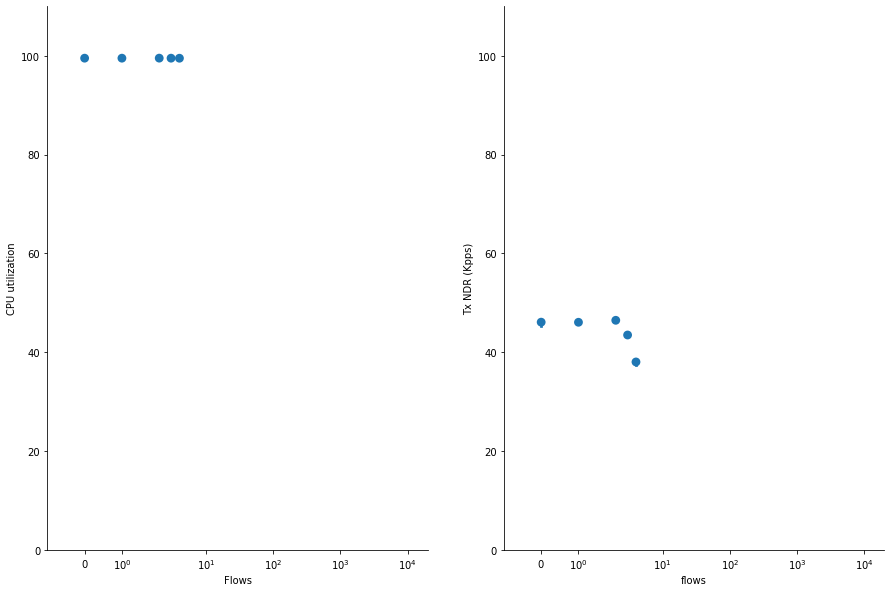

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

sns.pointplot(
    data = measurements_df,
    x = 'flows',
    y = 'cpu_util',
    join=False,
    ax = ax1
)

sns.pointplot(
    data = measurements_df,
    x = 'flows',
    y = measurements_df['tx_pps']/1000000,
    join=False,
    ax = ax2
)

ax1.set(
    ylim = [0, 110],
    xlim = [-1, 20000],
    xscale = 'symlog',
    ylabel = 'CPU utilization',
    xlabel = 'Flows'
       )

ax2.set(
    ylim = [0, 110],
    xlim = [-1, 20000],
    xscale = 'symlog',
    ylabel = 'Tx NDR (Kpps)'
       )

sns.despine()